# Regression on temporal dimension

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import copy
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler


Bad key text.latex.unicode in file /home/jtl/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key text.latex.preview in file /home/jtl/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 125 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/jtl/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 157 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')


In [2]:
with open('../../data/03_processed/boston_temporal_daily_activities.pickle', 'rb') as f:
    boston_dic = pickle.load(f)

In [3]:
with open('../../data/02_intermediate/boston_stays.pickle', 'rb') as f:
    df_boston = pickle.load(f)

In [4]:
with open("../../data/02_intermediate/miami_stays.pickle", 'rb') as f:
    df_miami = pickle.load(f)

In [5]:
with open("../../data/02_intermediate/chicago_stays.pickle", 'rb') as f:
    df_chicago = pickle.load(f)

In [6]:
# 
df_dic={}
df_dic['boston']=df_boston
df_dic['chicago']=df_miami
df_dic['miami']=df_chicago

In [7]:
# output from model_01
with open('../../data/05_model_outputs/lasso_coefficients.pickle', 'rb') as f:
    coeff_dic = pickle.load(f)

In [8]:
with open('../../data/03_processed/temporal_daily_activities.pickle', 'rb') as f:
    time_series_activities = pickle.load(f)

## preprocessing

#### Create the aggregate time series (TBD)

In [9]:
# create the aggregate data set
time_series_activities_ = copy.copy(time_series_activities)

for city in ['boston','chicago','miami']:
    for key_ in time_series_activities_[city].keys():
        time_series_activities_[city][key_] = pd.Series(time_series_activities_[city][key_])

    time_series_df = pd.concat(time_series_activities_[city], axis = 1)
    time_series_activities[city]['aggregate'] = time_series_df.sum(axis = 1)

# removing the first and last day. 
for city in ['boston','chicago','miami']:
    for key_ in time_series_activities[city].keys():
        time_series_activities[city][key_] = time_series_activities[city][key_][1:-1].values
        

In [10]:
# test
time_series_activities['boston']['aggregate']

array([65017, 57574, 74530, 77302, 78550, 80547, 79542, 68717, 53841,
       68199, 77508, 78314, 80720, 81672, 69977, 61760, 78844, 79794,
       81762, 80758, 80754, 70701, 60003, 76081, 77973, 79759, 79841,
       80700, 72326, 61056, 81821, 83796, 85589, 85969, 88129, 76854,
       67032, 83602, 85842, 86557, 86449, 80041, 74073, 66375, 81051,
       82407, 85135, 86002, 88210, 79101, 66786, 83507, 86062, 82046,
       46005, 69969, 66154, 60261, 80698, 81806, 84349, 87404, 87323,
       75956, 67100, 80842, 83633, 83633, 86892, 87638, 77556, 67628,
       82962, 83149, 79183, 82856, 84064, 69975, 63890, 79466, 78603,
       77596, 78186, 77331, 56225, 34365, 51497, 64556, 65411, 63916,
       66037, 57668, 43817, 54338, 65740, 69769, 69891, 71223, 54680,
       53656, 66095, 66635, 69575, 69501, 69464, 59800, 51538, 59936,
       67390, 66302, 69279, 69235, 62033, 52215, 65157, 65356, 68758,
       68309, 69049, 59425, 51679, 65707, 67714, 66995, 66607, 67640,
       58618, 47714,

#### Create the top 20 strong mobility ties

In [11]:
# Sort the activities according to their counts

# boston
activity_counts_boston = np.unique(df_boston.cat, return_counts = True)

# miami
activity_counts_miami = np.unique(df_miami.cat, return_counts = True)

# chicago
activity_counts_chicago = np.unique(df_chicago.cat, return_counts = True)

# convert the counts to df
activity_counts_dic = {}
activity_counts_dic['boston']=activity_counts_boston
activity_counts_dic['miami']=activity_counts_miami
activity_counts_dic['chicago']=activity_counts_chicago
# activity_counts_dic['nyc']=activity_counts_nyc

# turn them to dataframes
activity_counts_df_dic = {}
for key_ in activity_counts_dic.keys():
    activity_counts = activity_counts_dic[key_]
    activity_count_df = pd.DataFrame(activity_counts[1],
                                 index = activity_counts[0],
                                 columns = ['count'])
    sorted_activity_count_df = activity_count_df.sort_values('count', ascending=False)
    activity_counts_df_dic[key_] = sorted_activity_count_df

activity_counts_df_dic

{'boston':               count
 Office       572310
 Residential  392909
 Building     317220
 Automotive   234480
 Church       217515
 ...             ...
 Romanian          6
 Observatory       5
 Roller Rink       4
 Outdoor Gym       1
 Canal             1
 
 [633 rows x 1 columns],
 'miami':                        count
 Residential          2490430
 Office               1992101
 Building             1716251
 Pool                 1129853
 Housing Development   931943
 ...                      ...
 Chairlift                 13
 Used Bookstore            10
 Bay                        5
 Tunnel                     3
 Rafting                    2
 
 [630 rows x 1 columns],
 'chicago':                   count
 Office          3030244
 Building        2852654
 Church          2102629
 Residential     1770161
 Automotive      1479986
 ...                 ...
 Shabu-Shabu          19
 Racecourse           18
 Stoop Sale           14
 Music Festival       11
 Pet Café              1
 
 [

In [12]:
# Return top 20 mobility ties
top_20_mobility_ties = {}
for city in activity_counts_df_dic.keys():
    top_20_mobility_ties[city] = list(activity_counts_df_dic[city].index[:20])

top_20_mobility_ties

{'boston': ['Office',
  'Residential',
  'Building',
  'Automotive',
  'Church',
  'Salon / Barbershop',
  "Doctor's Office",
  'Pizza',
  'American',
  'Gas Station',
  'Gym',
  'Road',
  'Bank',
  'Donuts',
  'Hardware',
  'Grocery Store',
  'Supermarket',
  'Bar',
  "Dentist's Office",
  'Convenience Store'],
 'miami': ['Residential',
  'Office',
  'Building',
  'Pool',
  'Housing Development',
  'Automotive',
  'Church',
  "Doctor's Office",
  'Grocery Store',
  'Road',
  'Gym',
  'Salon / Barbershop',
  'Park',
  'Gas Station',
  'Fast Food',
  'American',
  'Hardware',
  'Bank',
  'Gym / Fitness',
  'Bar'],
 'chicago': ['Office',
  'Building',
  'Church',
  'Residential',
  'Automotive',
  'Salon / Barbershop',
  "Doctor's Office",
  'Park',
  'Gas Station',
  'Bar',
  'Road',
  'Hardware',
  'Fast Food',
  'Bank',
  'Elementary School',
  'Gym',
  'Factory',
  'American',
  'School',
  'Pizza']}

#### Create the predictive mobility ties

In [13]:
# find the predictive mobility ties
city_list = ['boston', 'chicago', 'miami']
output_list = ['inc_median_household_2018', 'property_value_median_2018', 'rent_median_2018']

# 
coeff_dic_for_df = {}

# pd.DataFrame(np.zeros((15, 3*3)), 
#                         columns = list(itertools.product(city_list, output_list)))

for city in city_list:
    for output in output_list:
        print(city, output)
        coeff_dic_for_df[(city, output)] = copy.copy(coeff_dic[city][output]['lasso (no socio-demographics)'])
        coeff_dic_for_df[(city, output)] = coeff_dic_for_df[(city, output)].reset_index()

coeff_dic_df = pd.concat(coeff_dic_for_df, axis = 1)
coeff_dic_df.index += 1
coeff_dic_df


boston inc_median_household_2018
boston property_value_median_2018
boston rent_median_2018
chicago inc_median_household_2018
chicago property_value_median_2018
chicago rent_median_2018
miami inc_median_household_2018
miami property_value_median_2018
miami rent_median_2018


boston                                                 \
   inc_median_household_2018           property_value_median_2018             
                       index     value                      index     value   
1             Latin American -0.052719             Discount Store -0.045884   
2                  Caribbean -0.047442          Convenience Store -0.042458   
3                  Brazilian -0.033213                   Hot Dogs -0.032983   
4              Fried Chicken -0.026100                 Car Washes -0.029239   
5                 Laundromat -0.020124             Latin American -0.026444   
6                 Food Stand  0.022041                     Tattoo -0.024189   
7               Tennis Court  0.022838                  Brazilian -0.022922   
8              Fishing Store  0.024188                Video Games -0.021531   
9                   Football  0.024686                 Strip Club -0.021167   
10            Science Museum  0.027285                 Art Museum  0.023082   
11                  Ski Area  0.028614                  Locksmith  0.025664   
12               Peking Duck  0.039055                     Bagels  0.028036   
13                  Cupcakes  0.042785               Cycle Studio  0.071260   
14              Skating Rink  0.062328                      Salad  0.083690   
15                    French  0.077346                     French  0.098779   

                                                 chicago            \
    rent_median_2018           inc_median_household_2018             
               index     value                     index     value   
1   Thrift / Vintage -0.021420            Discount Store -0.075285   
2        Pet Service -0.020264                 Caribbean -0.037931   
3          Caribbean -0.013465     Check Cashing Service -0.023629   
4           Hot Dogs -0.012142                Laundromat -0.013066   
5            Spanish -0.011805                Basketball  0.011197   
6            Storage -0.008046                   Volcano  0.013246   
7     Indian Chinese  0.007915                    Kosher  0.015703   
8            Noodles  0.010422            Pilates Studio  0.018776   
9        Engineering  0.012647            Kitchen Supply  0.026679   
10         Gastropub  0.014216              Skating Rink  0.037587   
11        University  0.015297                    Bagels  0.048831   
12         Synagogue  0.015579              New American  0.050781   
13    Sorority House  0.015651                    French  0.056830   
14        Art Museum  0.032275                    Hockey  0.058820   
15            French  0.053463               Golf Course  0.087332   

                                                                             \
   property_value_median_2018                    rent_median_2018             
                        index     value                     index     value   
1              Discount Store -0.159125            Discount Store -0.022832   
2                        Food -0.053095     Check Cashing Service -0.020628   
3                   Pawn Shop -0.036316                Laundromat -0.019881   
4                      Buffet -0.027311  Grilled Meat Restaurants  0.008300   
5                   Caribbean -0.023099              North Indian  0.008355   
6              Pilates Studio  0.011978         Recreation Center  0.009067   
7                Climbing Gym  0.013067            Kitchen Supply  0.009529   
8                Tennis Court  0.015707              Tennis Court  0.011599   
9                 Yoga Studio  0.019551             Travel Agency  0.015356   
10                    Gourmet  0.024067                Basketball  0.015599   
11                     Hockey  0.038779               Golf Course  0.016951   
12                     Kosher  0.044662                    French  0.017848   
13                Curling Ice  0.048627                    Kosher  0.026083   
14               New American  0.092229                    Bagels  0.04756

In [14]:
# creating the dictionary for the predictive mobility ties
predictive_mobility_ties = {}

for city in city_list:
    predictive_mobility_ties_list = []
    for output in output_list:
        predictive_mobility_ties_list.extend(list(coeff_dic_df[(city, output, 'index')].values))
    predictive_mobility_ties[city]=np.unique(predictive_mobility_ties_list)
    
predictive_mobility_ties

{'boston': array(['Art Museum', 'Bagels', 'Brazilian', 'Car Washes', 'Caribbean',
        'Convenience Store', 'Cupcakes', 'Cycle Studio', 'Discount Store',
        'Engineering', 'Fishing Store', 'Food Stand', 'Football', 'French',
        'Fried Chicken', 'Gastropub', 'Hot Dogs', 'Indian Chinese',
        'Latin American', 'Laundromat', 'Locksmith', 'Noodles',
        'Peking Duck', 'Pet Service', 'Salad', 'Science Museum',
        'Skating Rink', 'Ski Area', 'Sorority House', 'Spanish', 'Storage',
        'Strip Club', 'Synagogue', 'Tattoo', 'Tennis Court',
        'Thrift / Vintage', 'University', 'Video Games'], dtype='<U17'),
 'chicago': array(['Bagels', 'Basketball', 'Buffet', 'Caribbean',
        'Check Cashing Service', 'Climbing Gym', 'Curling Ice',
        'Discount Store', 'Food', 'French', 'Golf Course', 'Gourmet',
        'Grilled Meat Restaurants', 'Hockey', 'Kitchen Supply', 'Kosher',
        'Laundromat', 'New American', 'North Indian', 'Pawn Shop',
        'Pilates St

## Predicting the times series using aggregate, strong, and weak mobility ties

In [17]:
# define a function to run regression.
def time_series_reg(time_series, prediction = False):
    # create the dataframe
    activity_df = pd.DataFrame(time_series, columns = ['count'])

    # Creating the six time dummies
    time_0=pd.DataFrame(np.int_(np.array(activity_df.index) % 7 == 0), columns = ['tmp_0'])
    time_1=pd.DataFrame(np.int_(np.array(activity_df.index) % 7 == 1), columns = ['tmp_1'])
    time_2=pd.DataFrame(np.int_(np.array(activity_df.index) % 7 == 2), columns = ['tmp_2'])
    time_3=pd.DataFrame(np.int_(np.array(activity_df.index) % 7 == 3), columns = ['tmp_3'])
    time_4=pd.DataFrame(np.int_(np.array(activity_df.index) % 7 == 4), columns = ['tmp_4'])
    time_5=pd.DataFrame(np.int_(np.array(activity_df.index) % 7 == 5), columns = ['tmp_5'])

    # Creating the three degree polynomials
    poly_1d=pd.DataFrame(np.array(activity_df.index)/len(np.array(activity_df.index)), columns=['poly_1d']) # normalize it
    poly_2d=pd.DataFrame(np.array(activity_df.index)**2/len(np.array(activity_df.index)), columns=['poly_2d'])
    poly_3d=pd.DataFrame(np.array(activity_df.index)**3/len(np.array(activity_df.index)), columns=['poly_3d'])

    activity_df = pd.concat([activity_df,time_0,time_1,time_2,time_3,time_4,time_5,poly_1d,poly_2d,poly_3d], axis = 1)
    activity_df
    
    # OLS
    y = activity_df['count']
    X = activity_df[['tmp_0','tmp_1','tmp_2','tmp_3','tmp_4','tmp_5','poly_1d','poly_2d','poly_3d']]
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    y_pred = results.predict(X)

    # 
    if prediction:
        return results.rsquared, y_pred
    else:
        return results.rsquared

    

In [18]:
# test
city = 'boston'
activity_name = 'ATM'
time_series_reg(time_series_activities[city][activity_name])
time_series_reg(time_series_activities[city][activity_name], prediction = True)

(0.5854639757177854,
 0      69.631124
 1      56.333283
 2      74.573985
 3      82.115513
 4      76.688635
          ...    
 178    46.441361
 179    40.637393
 180    38.532598
 181    42.011594
 182    33.819337
 Length: 183, dtype: float64)

In [19]:
# compute the R2 performance for the 3 cities and 3 groups of mobility ties.
temporal_prediction_performance = {}
city_list = ['boston','chicago','miami']
type_categories = ['aggregate', 'strong', 'weak']

for city in city_list:
    # city 
    temporal_prediction_performance[city] = {}
    for type_ in type_categories:
        print(type_)
        temporal_prediction_performance[city][type_] = {}
        # 
        if type_ == 'aggregate':
            activity_name = 'aggregate'
            r2_performance = time_series_reg(time_series_activities[city][activity_name])
            temporal_prediction_performance[city][type_][activity_name] = r2_performance # save the aggregate result

        elif type_ == 'strong':
            for activity_name in top_20_mobility_ties[city]:
                r2_performance = time_series_reg(time_series_activities[city][activity_name])
                temporal_prediction_performance[city][type_][activity_name] = r2_performance # save 

        elif type_ == 'weak':
            for activity_name in predictive_mobility_ties[city]:
                r2_performance = time_series_reg(time_series_activities[city][activity_name])
                temporal_prediction_performance[city][type_][activity_name] = r2_performance # save 



aggregate
strong
weak
aggregate
strong
weak
aggregate
strong
weak


## Creating 3*3 visualization

aggregate
0.8469959929671144


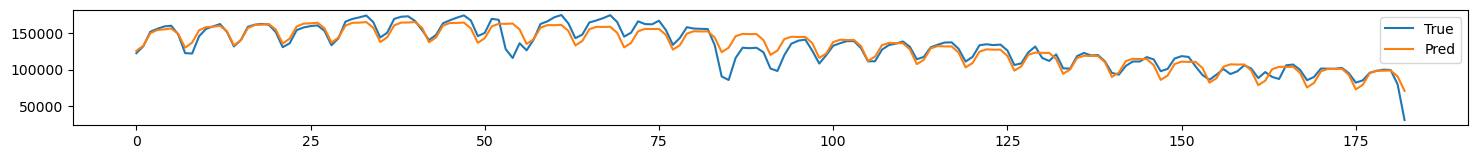

Office
0.8151544828278091


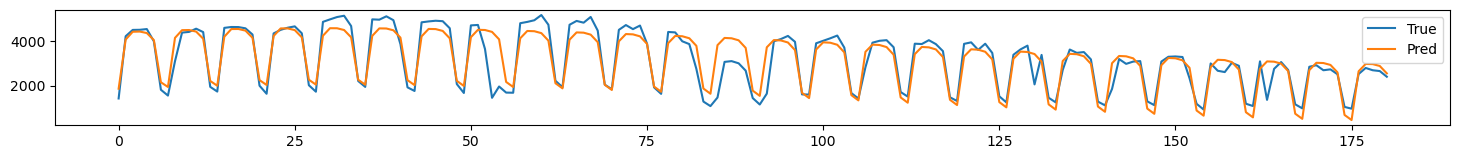

French
0.43697459697240415


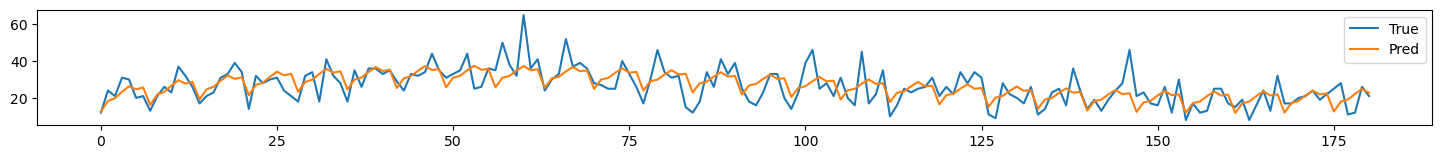

In [100]:
# Boston
city = 'boston'
for activity_name in ['aggregate', 'Office', 'French']:
    print(activity_name)
    r2_performance, y_pred = time_series_reg(time_series_activities[city][activity_name], prediction = True)
    print(r2_performance)
    
    # Visualize
    plt.figure(figsize = (18, 1.5))
    y_true_line = plt.plot(time_series_activities[city][activity_name], label = 'True')
    y_pred_line = plt.plot(y_pred, label = 'Pred')
    plt.legend(loc='upper right')
    plt.show()


aggregate
0.8807342109189339


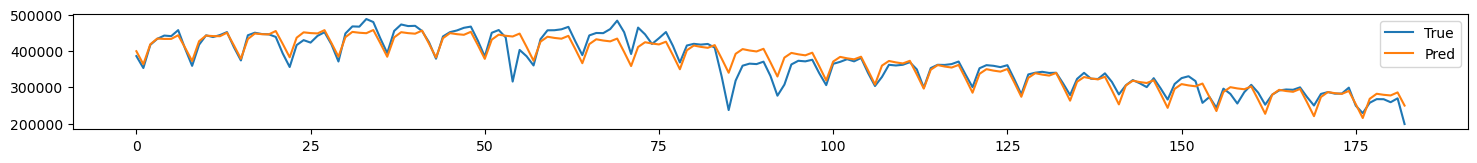

Residential
0.8828847699320348


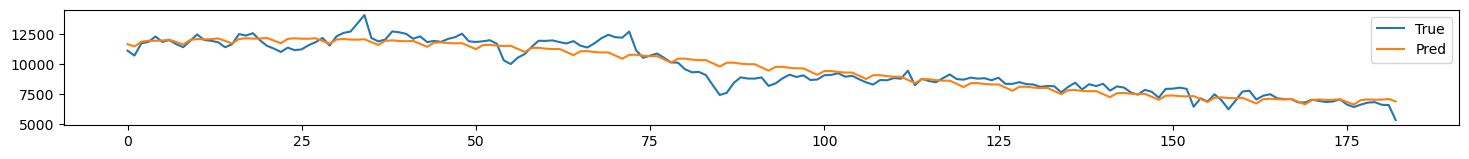

Pilates Studio
0.4321775901132582


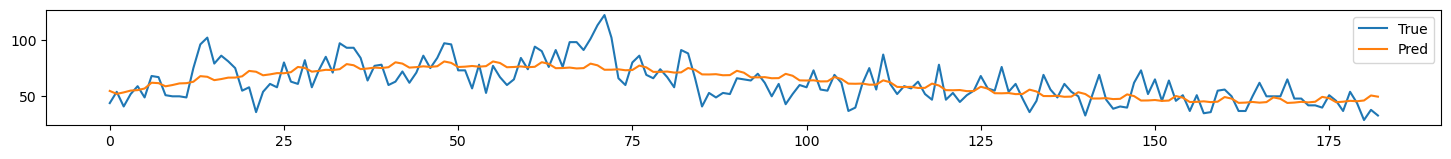

In [25]:
# Chicago
city = 'chicago'
for activity_name in ['aggregate', "Residential", 'Pilates Studio']:
    print(activity_name)
    r2_performance, y_pred = time_series_reg(time_series_activities[city][activity_name], prediction = True)
    print(r2_performance)
    
    # Visualize
    plt.figure(figsize = (18, 1.5))
    y_true_line = plt.plot(time_series_activities[city][activity_name], label = 'True')
    y_pred_line = plt.plot(y_pred, label = 'Pred')
    plt.legend(loc='upper right')
    plt.show()


aggregate
0.8219750351056583


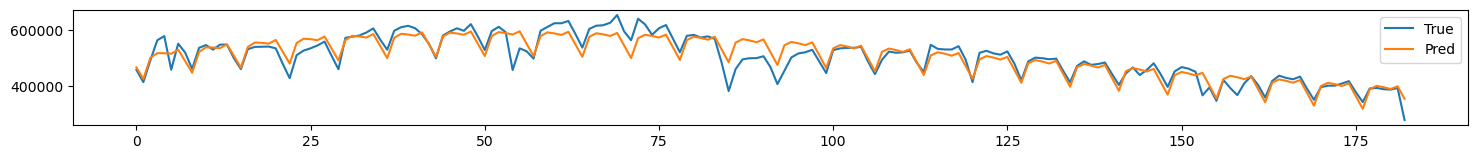

Automotive
0.8448311135572717


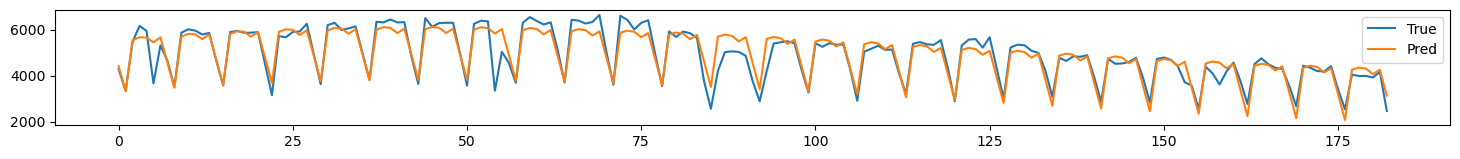

Tennis Court
0.6061737065345145


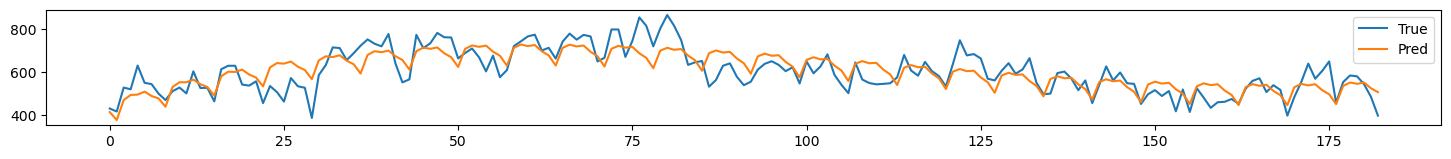

In [102]:
# Miami
city = 'miami'
for activity_name in ['aggregate', 'Automotive', 'Tennis Court']:
    print(activity_name)
    r2_performance, y_pred = time_series_reg(time_series_activities[city][activity_name], prediction = True)
    print(r2_performance)
    
    # Visualize
    plt.figure(figsize = (18, 1.5))
    y_true_line = plt.plot(time_series_activities[city][activity_name], label = 'True')
    y_pred_line = plt.plot(y_pred, label = 'Pred')
    plt.legend(loc='upper right')
    plt.show()

# Save

In [104]:
with open('../../data/05_model_outputs/temporal_performance.pickle','wb') as f:
    pickle.dump(temporal_prediction_performance, f)